# PreTrain

In [1]:
from model.sswae_dev2_2 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 8
rm = [3,6]

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10 - len(rm) + 1),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [i for i in range(10) if i not in rm]
print("lab:", labeled_class, "rm:", rm)
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, unk=True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

lab: [0, 1, 2, 4, 5, 7, 8, 9] rm: [3, 6]


In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.262
[2] loss: 0.197
[3] loss: 0.050
[4] loss: 0.028
[5] loss: 0.019
[6] loss: 0.013
[7] loss: 0.012
[8] loss: 0.010
[9] loss: 0.008
[10] loss: 0.006
[11] loss: 0.006
[12] loss: 0.007
[13] loss: 0.003
[14] loss: 0.004
[15] loss: 0.004
[16] loss: 0.006
[17] loss: 0.003
[18] loss: 0.002
[19] loss: 0.004
[20] loss: 0.003


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 8])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

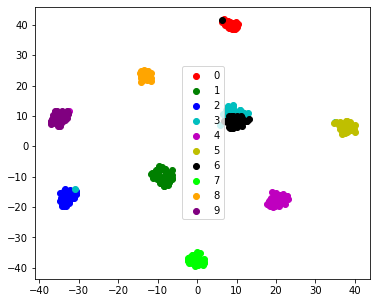

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

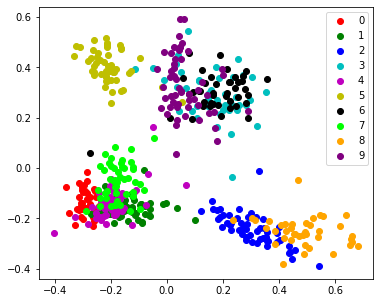

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, class_no = True, unk=True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10 - len(rm) + 1, y_dim))
cs = np.zeros(10 - len(rm) + 1)
covs = np.zeros((10 - len(rm) + 1, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10 - len(rm) + 1, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10 - len(rm)):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[-0.2803, -0.1472,  0.3086, -0.1966, -0.2096, -0.1821,  0.4482,  0.0410,
          0.1525],
        [-0.2237, -0.2682,  0.1891,  0.4730, -0.2257, -0.2021, -0.2479, -0.2364,
          0.2758],
        [-0.1321, -0.1608, -0.2549, -0.1464,  0.3934, -0.0581, -0.2418,  0.3445,
          0.2903],
        [ 0.5364, -0.1385,  0.2402, -0.2365, -0.2371,  0.3671, -0.2082, -0.2267,
         -0.0577],
        [-0.1154,  0.5677, -0.0684, -0.1336, -0.1539, -0.0758,  0.1282, -0.1182,
          0.3562],
        [-0.1174, -0.1242,  0.3114, -0.2056, -0.2380, -0.2354,  0.1494,  0.4431,
         -0.2103],
        [-0.3537,  0.1275, -0.2402,  0.2857,  0.1010,  0.3435, -0.1745,  0.3878,
         -0.3147],
        [ 0.4904, -0.0056, -0.1681,  0.1014,  0.4636, -0.1703,  0.3959, -0.2087,
         -0.0808]])

In [13]:
f1 = nn.Linear(10 - len(rm) + 1, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)
w2.shape

torch.Size([9, 8, 8])

In [15]:
for i in range(10 - len(rm) + 1):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10 - len(rm) + 1, 1, y_dim, bias=False)
f2.weight.data = w2.view(10 - len(rm) + 1, 1, y_dim, y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt')

# Train

In [17]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_rm_3,6_unk.cfg')

['./config/sswae_dev2_rm_3,6_unk.cfg']

In [18]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 4
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 8
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,4,5,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 3,6
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] unk : True
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_ba

[default |INFO|model.py:1823] [01/80]  loss: 2.339347e-01  D: 6.925367e-01  D2: 3.368344e-02  D3: 1.950876e-03
test loss: 1.766938e-01  D: 7.027017e-01  D2: 1.080486e-02  D3: 7.731540e-03


[default |INFO|model.py:1823] [02/80]  loss: 1.670074e-01  D: 6.908624e-01  D2: 7.045428e-03  D3: 7.699619e-03
test loss: 1.470711e-01  D: 6.997130e-01  D2: 3.302145e-03  D3: 6.319588e-03


[default |INFO|model.py:1823] [03/80]  loss: 1.488082e-01  D: 6.930443e-01  D2: 9.520626e-04  D3: 9.075458e-03
test loss: 1.322205e-01  D: 6.911425e-01  D2: -5.594254e-05  D3: 9.086968e-03


[default |INFO|model.py:1823] [04/80]  loss: 1.125314e-01  D: 6.923577e-01  D2: -1.262531e-03  D3: 1.001572e-02
test loss: 1.008456e-01  D: 6.787408e-01  D2: -2.160187e-03  D3: 9.031973e-03


[default |INFO|model.py:1823] [05/80]  loss: 1.023944e-01  D: 6.928413e-01  D2: -2.272668e-03  D3: 1.165147e-02
test loss: 9.710584e-02  D: 7.189679e-01  D2: -2.361259e-03  D3: 1.260259e-02


[default |INFO|model.py:1823] [06/80]  loss: 9.394376e-02  D: 6.936056e-01  D2: -2.533712e-03  D3: 1.211742e-02
test loss: 8.506419e-02  D: 7.028146e-01  D2: -2.414122e-03  D3: 1.192166e-02


[default |INFO|model.py:1823] [07/80]  loss: 8.638606e-02  D: 6.943297e-01  D2: -2.559781e-03  D3: 1.297978e-02
test loss: 8.282520e-02  D: 7.011561e-01  D2: -2.763491e-03  D3: 1.107552e-02


[default |INFO|model.py:1823] [08/80]  loss: 7.989091e-02  D: 6.945208e-01  D2: -2.706801e-03  D3: 1.263576e-02
test loss: 7.676646e-02  D: 6.985143e-01  D2: -2.937450e-03  D3: 1.238486e-02


[default |INFO|model.py:1823] [09/80]  loss: 7.507058e-02  D: 6.938680e-01  D2: -3.071152e-03  D3: 1.231399e-02
test loss: 7.480172e-02  D: 6.995999e-01  D2: -3.061781e-03  D3: 1.187080e-02


[default |INFO|model.py:1823] [10/80]  loss: 7.147027e-02  D: 6.944602e-01  D2: -3.406477e-03  D3: 1.218195e-02
test loss: 6.802474e-02  D: 7.075532e-01  D2: -3.677511e-03  D3: 1.290880e-02


[default |INFO|model.py:1823] [11/80]  loss: 6.924350e-02  D: 6.944785e-01  D2: -3.780839e-03  D3: 1.190884e-02
test loss: 7.080741e-02  D: 6.902595e-01  D2: -4.508324e-03  D3: 1.040079e-02


[default |INFO|model.py:1823] [12/80]  loss: 6.777689e-02  D: 6.932266e-01  D2: -4.103521e-03  D3: 1.178981e-02
test loss: 6.699150e-02  D: 6.932480e-01  D2: -4.507179e-03  D3: 1.037504e-02


[default |INFO|model.py:1823] [13/80]  loss: 6.586220e-02  D: 6.941338e-01  D2: -4.231172e-03  D3: 1.202591e-02
test loss: 6.543648e-02  D: 6.911681e-01  D2: -3.969212e-03  D3: 9.913416e-03


[default |INFO|model.py:1823] [14/80]  loss: 6.480866e-02  D: 6.932986e-01  D2: -4.381450e-03  D3: 1.165473e-02
test loss: 6.296835e-02  D: 7.017169e-01  D2: -4.149923e-03  D3: 1.292194e-02


[default |INFO|model.py:1823] [15/80]  loss: 6.346716e-02  D: 6.929991e-01  D2: -4.485413e-03  D3: 1.188422e-02
test loss: 6.371739e-02  D: 7.166376e-01  D2: -5.186930e-03  D3: 1.149829e-02


[default |INFO|model.py:1823] [16/80]  loss: 6.225951e-02  D: 6.942027e-01  D2: -4.551977e-03  D3: 1.184957e-02
test loss: 6.033978e-02  D: 6.864314e-01  D2: -5.227633e-03  D3: 1.196873e-02


[default |INFO|model.py:1823] [17/80]  loss: 6.175983e-02  D: 6.944544e-01  D2: -4.903413e-03  D3: 1.153009e-02
test loss: 6.206385e-02  D: 6.943753e-01  D2: -4.819002e-03  D3: 1.268723e-02


[default |INFO|model.py:1823] [18/80]  loss: 5.995435e-02  D: 6.934226e-01  D2: -4.984797e-03  D3: 1.174765e-02
test loss: 5.918651e-02  D: 6.913102e-01  D2: -4.913502e-03  D3: 1.180110e-02


[default |INFO|model.py:1823] [19/80]  loss: 5.913204e-02  D: 6.935036e-01  D2: -5.025053e-03  D3: 1.152023e-02
test loss: 6.043877e-02  D: 7.024556e-01  D2: -4.471903e-03  D3: 1.200027e-02


[default |INFO|model.py:1823] [20/80]  loss: 5.833907e-02  D: 6.936322e-01  D2: -5.175568e-03  D3: 1.168584e-02
test loss: 5.877125e-02  D: 6.857162e-01  D2: -5.443411e-03  D3: 1.052183e-02


[default |INFO|model.py:1823] [21/80]  loss: 5.679549e-02  D: 6.934336e-01  D2: -5.399528e-03  D3: 1.177980e-02
test loss: 5.648610e-02  D: 6.934197e-01  D2: -5.231304e-03  D3: 1.181725e-02


[default |INFO|model.py:1823] [22/80]  loss: 5.693036e-02  D: 6.934380e-01  D2: -5.453540e-03  D3: 1.144288e-02
test loss: 5.703193e-02  D: 7.047585e-01  D2: -5.775013e-03  D3: 1.076932e-02


[default |INFO|model.py:1823] [23/80]  loss: 5.676976e-02  D: 6.939676e-01  D2: -5.517915e-03  D3: 1.161877e-02
test loss: 5.867095e-02  D: 6.951583e-01  D2: -5.513887e-03  D3: 1.120681e-02


[default |INFO|model.py:1823] [24/80]  loss: 5.651251e-02  D: 6.935377e-01  D2: -5.578047e-03  D3: 1.147365e-02
test loss: 5.542350e-02  D: 6.951083e-01  D2: -5.615759e-03  D3: 1.185037e-02


[default |INFO|model.py:1823] [25/80]  loss: 5.653940e-02  D: 6.932476e-01  D2: -5.549506e-03  D3: 1.151617e-02
test loss: 5.616450e-02  D: 6.898832e-01  D2: -5.978994e-03  D3: 1.272732e-02


[default |INFO|model.py:1823] [26/80]  loss: 5.400525e-02  D: 6.933264e-01  D2: -5.875276e-03  D3: 1.159637e-02
test loss: 5.386877e-02  D: 6.915565e-01  D2: -6.557722e-03  D3: 1.238990e-02


[default |INFO|model.py:1823] [27/80]  loss: 5.423272e-02  D: 6.935321e-01  D2: -5.923368e-03  D3: 1.159449e-02
test loss: 5.530343e-02  D: 6.931828e-01  D2: -5.808659e-03  D3: 1.194073e-02


[default |INFO|model.py:1823] [28/80]  loss: 5.386843e-02  D: 6.934995e-01  D2: -5.985964e-03  D3: 1.164308e-02
test loss: 5.586658e-02  D: 6.998656e-01  D2: -6.264944e-03  D3: 1.108438e-02


[default |INFO|model.py:1823] [29/80]  loss: 5.426551e-02  D: 6.933324e-01  D2: -5.981827e-03  D3: 1.143181e-02
test loss: 5.407489e-02  D: 6.862117e-01  D2: -6.239223e-03  D3: 1.075991e-02


[default |INFO|model.py:1823] [30/80]  loss: 5.268489e-02  D: 6.935126e-01  D2: -6.158627e-03  D3: 1.149760e-02
test loss: 5.465674e-02  D: 6.933649e-01  D2: -6.705799e-03  D3: 1.153688e-02


[default |INFO|model.py:1823] [31/80]  loss: 5.311800e-02  D: 6.937390e-01  D2: -6.134192e-03  D3: 1.142919e-02
test loss: 5.280687e-02  D: 7.024898e-01  D2: -6.353016e-03  D3: 1.172193e-02


[default |INFO|model.py:1823] [32/80]  loss: 5.215158e-02  D: 6.931223e-01  D2: -6.479656e-03  D3: 1.145486e-02
test loss: 5.538422e-02  D: 6.958310e-01  D2: -6.757898e-03  D3: 1.231961e-02


[default |INFO|model.py:1823] [33/80]  loss: 5.212393e-02  D: 6.933065e-01  D2: -6.398664e-03  D3: 1.154047e-02
test loss: 5.286675e-02  D: 6.963987e-01  D2: -6.480312e-03  D3: 1.242890e-02


[default |INFO|model.py:1823] [34/80]  loss: 5.177252e-02  D: 6.932812e-01  D2: -6.460230e-03  D3: 1.133983e-02
test loss: 5.239149e-02  D: 6.852796e-01  D2: -6.966867e-03  D3: 1.121550e-02


[default |INFO|model.py:1823] [35/80]  loss: 5.212909e-02  D: 6.938024e-01  D2: -6.575623e-03  D3: 1.128978e-02
test loss: 5.301448e-02  D: 6.924262e-01  D2: -7.086716e-03  D3: 9.759682e-03


[default |INFO|model.py:1823] [36/80]  loss: 5.159921e-02  D: 6.932212e-01  D2: -6.556393e-03  D3: 1.128961e-02
test loss: 5.228013e-02  D: 6.976629e-01  D2: -6.823263e-03  D3: 1.110535e-02


[default |INFO|model.py:1823] [37/80]  loss: 5.089124e-02  D: 6.932771e-01  D2: -6.666929e-03  D3: 1.130782e-02
test loss: 5.197034e-02  D: 6.954766e-01  D2: -6.518431e-03  D3: 1.121497e-02


[default |INFO|model.py:1823] [38/80]  loss: 5.128157e-02  D: 6.931827e-01  D2: -6.773539e-03  D3: 1.127817e-02
test loss: 5.450452e-02  D: 6.897693e-01  D2: -6.538258e-03  D3: 1.170827e-02


[default |INFO|model.py:1823] [39/80]  loss: 5.141361e-02  D: 6.933508e-01  D2: -6.810430e-03  D3: 1.124493e-02
test loss: 5.500966e-02  D: 6.872144e-01  D2: -7.163143e-03  D3: 9.682768e-03


[default |INFO|model.py:1823] [40/80]  loss: 5.087324e-02  D: 6.936723e-01  D2: -6.878816e-03  D3: 1.114340e-02
test loss: 5.172323e-02  D: 6.858412e-01  D2: -6.979036e-03  D3: 1.136286e-02


[default |INFO|model.py:1823] [41/80]  loss: 5.110750e-02  D: 6.932806e-01  D2: -6.864939e-03  D3: 1.117984e-02
test loss: 5.334511e-02  D: 7.001505e-01  D2: -6.702290e-03  D3: 1.112140e-02


[default |INFO|model.py:1823] [42/80]  loss: 5.035634e-02  D: 6.934032e-01  D2: -6.949817e-03  D3: 1.128217e-02
test loss: 5.190039e-02  D: 6.921183e-01  D2: -7.205811e-03  D3: 1.128121e-02


[default |INFO|model.py:1823] [43/80]  loss: 5.030020e-02  D: 6.932120e-01  D2: -6.988656e-03  D3: 1.115708e-02
test loss: 5.187496e-02  D: 6.897253e-01  D2: -6.867113e-03  D3: 1.160192e-02


[default |INFO|model.py:1823] [44/80]  loss: 4.966913e-02  D: 6.930547e-01  D2: -7.151151e-03  D3: 1.123432e-02
test loss: 5.181033e-02  D: 6.914534e-01  D2: -7.350903e-03  D3: 1.019031e-02


[default |INFO|model.py:1823] [45/80]  loss: 5.004033e-02  D: 6.933480e-01  D2: -7.137497e-03  D3: 1.112274e-02
test loss: 4.961176e-02  D: 6.932072e-01  D2: -7.262917e-03  D3: 1.073398e-02


[default |INFO|model.py:1823] [46/80]  loss: 4.944071e-02  D: 6.930797e-01  D2: -7.092670e-03  D3: 1.114107e-02
test loss: 5.079148e-02  D: 6.885982e-01  D2: -7.243900e-03  D3: 1.144881e-02


[default |INFO|model.py:1823] [47/80]  loss: 4.900938e-02  D: 6.933184e-01  D2: -7.253826e-03  D3: 1.112782e-02
test loss: 5.063052e-02  D: 6.947633e-01  D2: -7.187166e-03  D3: 1.096899e-02


[default |INFO|model.py:1823] [48/80]  loss: 4.924695e-02  D: 6.934763e-01  D2: -7.204701e-03  D3: 1.101768e-02
test loss: 5.218377e-02  D: 6.906525e-01  D2: -7.675400e-03  D3: 9.622829e-03


[default |INFO|model.py:1823] [49/80]  loss: 4.915692e-02  D: 6.930318e-01  D2: -7.331885e-03  D3: 1.119184e-02
test loss: 5.178661e-02  D: 6.950751e-01  D2: -6.930389e-03  D3: 1.071137e-02


[default |INFO|model.py:1823] [50/80]  loss: 4.894790e-02  D: 6.934828e-01  D2: -7.305082e-03  D3: 1.107263e-02
test loss: 5.136254e-02  D: 6.942041e-01  D2: -7.552729e-03  D3: 9.899159e-03


[default |INFO|model.py:1823] [51/80]  loss: 4.905460e-02  D: 6.929363e-01  D2: -7.377631e-03  D3: 1.111038e-02
test loss: 5.076534e-02  D: 6.797749e-01  D2: -7.213154e-03  D3: 1.068745e-02


[default |INFO|model.py:1823] [52/80]  loss: 4.875099e-02  D: 6.933428e-01  D2: -7.374927e-03  D3: 1.107049e-02
test loss: 5.182477e-02  D: 6.975654e-01  D2: -7.095852e-03  D3: 1.041490e-02


[default |INFO|model.py:1823] [53/80]  loss: 4.895556e-02  D: 6.932110e-01  D2: -7.417250e-03  D3: 1.100350e-02
test loss: 4.913120e-02  D: 6.930375e-01  D2: -7.450037e-03  D3: 1.042634e-02


[default |INFO|model.py:1823] [54/80]  loss: 4.816731e-02  D: 6.933633e-01  D2: -7.469916e-03  D3: 1.099081e-02
test loss: 4.928497e-02  D: 6.978699e-01  D2: -7.493610e-03  D3: 1.016398e-02


[default |INFO|model.py:1823] [55/80]  loss: 4.792356e-02  D: 6.930693e-01  D2: -7.606317e-03  D3: 1.100587e-02
test loss: 5.123318e-02  D: 6.899494e-01  D2: -7.688799e-03  D3: 1.048307e-02


[default |INFO|model.py:1823] [56/80]  loss: 4.809430e-02  D: 6.934386e-01  D2: -7.560569e-03  D3: 1.089269e-02
test loss: 4.987931e-02  D: 6.941810e-01  D2: -7.686062e-03  D3: 1.157019e-02


[default |INFO|model.py:1823] [57/80]  loss: 4.824478e-02  D: 6.932285e-01  D2: -7.546248e-03  D3: 1.096078e-02
test loss: 5.074252e-02  D: 7.051188e-01  D2: -7.498941e-03  D3: 1.209615e-02


[default |INFO|model.py:1823] [58/80]  loss: 4.829941e-02  D: 6.933161e-01  D2: -7.565517e-03  D3: 1.087588e-02
test loss: 4.982067e-02  D: 6.861134e-01  D2: -7.699404e-03  D3: 1.093134e-02


[default |INFO|model.py:1823] [59/80]  loss: 4.829575e-02  D: 6.930916e-01  D2: -7.697199e-03  D3: 1.099440e-02
test loss: 5.176104e-02  D: 6.872364e-01  D2: -7.683201e-03  D3: 9.718463e-03


[default |INFO|model.py:1823] [60/80]  loss: 4.842153e-02  D: 6.934045e-01  D2: -7.656460e-03  D3: 1.050931e-02
test loss: 5.027756e-02  D: 6.942908e-01  D2: -7.927332e-03  D3: 9.274045e-03


[default |INFO|model.py:1823] [61/80]  loss: 4.801416e-02  D: 6.934881e-01  D2: -7.632413e-03  D3: 1.075600e-02
test loss: 4.877594e-02  D: 6.920995e-01  D2: -7.793159e-03  D3: 1.058402e-02


[default |INFO|model.py:1823] [62/80]  loss: 4.752868e-02  D: 6.932734e-01  D2: -7.633429e-03  D3: 1.089731e-02
test loss: 4.979516e-02  D: 6.913515e-01  D2: -7.619982e-03  D3: 1.014486e-02


[default |INFO|model.py:1823] [63/80]  loss: 4.736390e-02  D: 6.931089e-01  D2: -7.839239e-03  D3: 1.076046e-02
test loss: 4.895855e-02  D: 6.983135e-01  D2: -7.822561e-03  D3: 1.071897e-02


[default |INFO|model.py:1823] [64/80]  loss: 4.746620e-02  D: 6.933904e-01  D2: -7.803580e-03  D3: 1.068143e-02
test loss: 4.967992e-02  D: 6.963154e-01  D2: -7.559195e-03  D3: 1.152596e-02


[default |INFO|model.py:1823] [65/80]  loss: 4.753540e-02  D: 6.931883e-01  D2: -7.838041e-03  D3: 1.065668e-02
test loss: 5.055979e-02  D: 6.879211e-01  D2: -7.660599e-03  D3: 1.036691e-02


[default |INFO|model.py:1823] [66/80]  loss: 4.753522e-02  D: 6.932938e-01  D2: -7.807738e-03  D3: 1.070813e-02
test loss: 4.854363e-02  D: 6.895521e-01  D2: -7.874575e-03  D3: 1.082296e-02


[default |INFO|model.py:1823] [67/80]  loss: 4.715868e-02  D: 6.933948e-01  D2: -7.883261e-03  D3: 1.073824e-02
test loss: 5.030131e-02  D: 6.929250e-01  D2: -8.134832e-03  D3: 1.029114e-02


[default |INFO|model.py:1823] [68/80]  loss: 4.677757e-02  D: 6.932808e-01  D2: -7.866138e-03  D3: 1.071384e-02
test loss: 4.973253e-02  D: 6.864392e-01  D2: -8.155174e-03  D3: 1.141210e-02


[default |INFO|model.py:1823] [69/80]  loss: 4.785227e-02  D: 6.930668e-01  D2: -7.885758e-03  D3: 1.053809e-02
test loss: 4.854845e-02  D: 6.876594e-01  D2: -8.011150e-03  D3: 1.065372e-02


[default |INFO|model.py:1823] [70/80]  loss: 4.709154e-02  D: 6.931452e-01  D2: -7.947739e-03  D3: 1.060330e-02
test loss: 4.935337e-02  D: 6.910563e-01  D2: -7.897758e-03  D3: 1.124013e-02


[default |INFO|model.py:1823] [71/80]  loss: 4.734587e-02  D: 6.932921e-01  D2: -7.944633e-03  D3: 1.060065e-02
test loss: 4.888868e-02  D: 6.886408e-01  D2: -8.072195e-03  D3: 1.081811e-02


[default |INFO|model.py:1823] [72/80]  loss: 4.672874e-02  D: 6.935657e-01  D2: -8.021123e-03  D3: 1.063473e-02
test loss: 4.815412e-02  D: 6.815527e-01  D2: -7.902641e-03  D3: 1.026282e-02


[default |INFO|model.py:1823] [73/80]  loss: 4.663828e-02  D: 6.932320e-01  D2: -7.973623e-03  D3: 1.070561e-02
test loss: 4.828795e-02  D: 6.932241e-01  D2: -8.268137e-03  D3: 1.049870e-02


[default |INFO|model.py:1823] [74/80]  loss: 4.642978e-02  D: 6.933479e-01  D2: -8.051880e-03  D3: 1.056374e-02
test loss: 4.838420e-02  D: 6.924749e-01  D2: -8.197298e-03  D3: 1.067611e-02


[default |INFO|model.py:1823] [75/80]  loss: 4.667113e-02  D: 6.927045e-01  D2: -8.013337e-03  D3: 1.061471e-02
test loss: 5.046120e-02  D: 6.944604e-01  D2: -7.959919e-03  D3: 1.026561e-02


[default |INFO|model.py:1823] [76/80]  loss: 4.643365e-02  D: 6.934740e-01  D2: -8.104769e-03  D3: 1.054472e-02
test loss: 4.872902e-02  D: 6.938670e-01  D2: -8.132849e-03  D3: 1.009816e-02


[default |INFO|model.py:1823] [77/80]  loss: 4.642628e-02  D: 6.935749e-01  D2: -8.060247e-03  D3: 1.052855e-02
test loss: 4.933007e-02  D: 6.929214e-01  D2: -8.104858e-03  D3: 9.742178e-03


[default |INFO|model.py:1823] [78/80]  loss: 4.699121e-02  D: 6.933525e-01  D2: -8.043054e-03  D3: 1.043847e-02
test loss: 4.992031e-02  D: 6.954549e-01  D2: -8.292522e-03  D3: 9.843149e-03


[default |INFO|model.py:1823] [79/80]  loss: 4.665182e-02  D: 6.933926e-01  D2: -8.127759e-03  D3: 1.042908e-02
test loss: 4.811937e-02  D: 6.916287e-01  D2: -8.049288e-03  D3: 1.069022e-02


[default |INFO|model.py:1823] [80/80]  loss: 4.632615e-02  D: 6.930853e-01  D2: -8.142451e-03  D3: 1.041292e-02
test loss: 4.954856e-02  D: 6.929734e-01  D2: -8.395205e-03  D3: 1.023762e-02


[default |INFO|model.py:1938] Training Finished!
[default |INFO|model.py:1939] Elapsed time: 2650.604s


# Test

In [19]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [20]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [21]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[-i])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

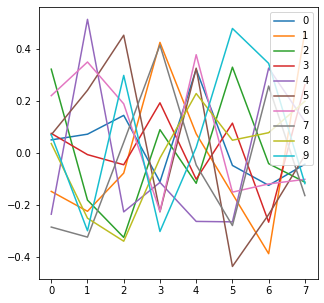

In [22]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

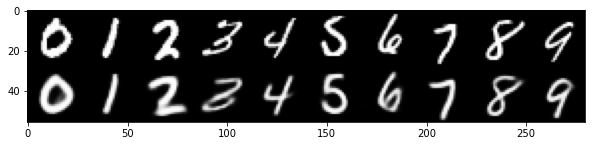

In [23]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [24]:
from XAE.sampler import gaus

exn = 5

In [25]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

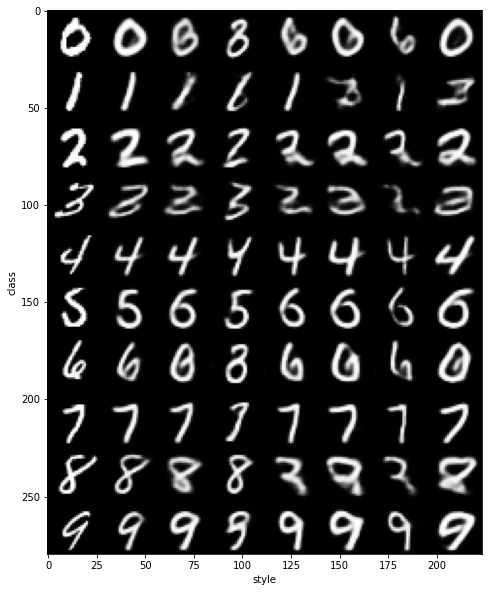

In [26]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [27]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

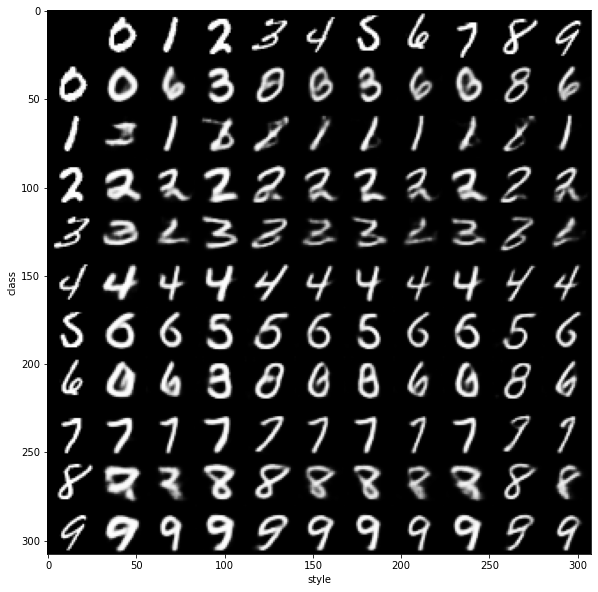

In [28]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()